## LISA PE with TaylorF2: adding biases from detector & confusion noise.

Pick the number of missed signals here. These will form confusion noise.

In [1]:
# Pick the number of missed signals (more on this below!)
N_missed = 50

In [2]:
# Import packages that you may already have pip installed in your environment.

import sys
import scipy

import numpy as np
import matplotlib.pyplot as plt
import time
from math import *
from scipy import signal
import os
import warnings

# Import other packages which are less common and specific to the task at hand.

from functions import *
import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches

# Initialize random number generator.
np.random.seed(12345)

### Generate reference signals in the time and frequency domains

Here we define the TaylorF2 approximant up to 1.5PN contributions.
References for TaylorF2 models

- https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)]
- https://arxiv.org/pdf/0907.0700.pdf [Eqs.(3.17)-(3.18)]

In [3]:
# Bunch of units

GM_sun = 1.3271244*1e20
c =2.9979246*1e8
M_sun =1.9884099*1e30
G = 6.6743*1e-11
pc= 3.0856776*1e16
pi = np.pi
Mpc = 10**6 * pc

In [4]:
def htilde(f,Deff,params,tune):
    
    """
    Here we calculate a TaylorF2 model up to 2PN which takes as input the following
    set of parameters: (log of chirp mass, symmetric mass ratio, beta).
    This can easily be changed in the first few lines where the parameters are loaded.
    The main reference is https://arxiv.org/pdf/gr-qc/0509116.pdf [Eqs (3.4)].
    
    Important:
    
    This model is defined in the frequency domain directly and it necessitates
    continuous fourier transforms in the inner products (no discretizations!)
    
    Note on distance: 
    
    Notice that the effective distance contains information about the angular dependence
    of the binary. The model can thus be used for all detectors, as long as this distance
    parameter is chosen consistently. 
    
    Note on spin: 
    
    The spin parameter beta is defined in Eq.(2.3a) in [arxiv:0411129].
    Notice that this quantity is constructed in such a way to be smaller or equal
    than 9.4, and of course it ranges from 0 (no spins) to this upper value. 
    The coefficient enters the phase as in Eq.(2.2) in the same paper.
    
    Note on 'tune':
    
    This is a tuning parameter. If tune=1, then we have the 3.5PN waveform.
    If tune is not 1, then we introduce a systematic error into the model.
    
    """
    # Units
    
    GM_sun = 1.3271244*1e20
    c =2.9979246*1e8
    M_sun =1.9884099*1e30
    G = 6.6743*1e-11
    pc= 3.0856776*1e16
    pi = np.pi
    Mpc = 10**6 * pc
    
    # Load the parameters
    Mchirp_true = np.exp(params[0])
    eta_true = params[1]
    beta_true = params[2]
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    
    # PN expansion parameter (velocity).
    v = (pi*G*Mchirp_true*eta_true**(-3/5)/(c**3) * f)**(1/3)
    
    # Amplitude explicitly given in terms of units and frequency.
    # Notice that lowest PN order here is fine. Biggest contributions from phase.
    amplitude_1 = - (Mpc/Deff)*np.sqrt((5/(24*pi)))*(GM_sun/(c**2 *Mpc))
    amplitude_2 = (pi*GM_sun/(c**3))**(-1/6) * (Mchirp_true/M_sun)**(5/6)
    amplitude = amplitude_1*amplitude_2 * f**(-7/6)
    
    # Phase: add or remove PN orders here as you see fit.
    psi_const = 2*pi*f*t0 - 2*phi0 - pi/4
    psi1PN = (3715/756+55/9*eta_true)*v**(-3)
    psi1_5PN_tails = -16*pi*v**(-2)
    psi1_5PN_spin = 4*beta_true*v**(-2)
    psi2PN = (15293365/508032+27145/504*eta_true+3085/72*eta_true**2)*v**(-1)
    psi25PNlog = pi*(38645/252- 65/3 *eta_true)* np.log(v)
    psi3PN = v*(11583231236531/4694215680 -640/3 * pi**2 -6848/21 *np.euler_gamma
              + eta_true*(-15335597827/3048192+2255/12 * pi**2-1760/3 * theta - 12320/9 * delta)
              + eta_true**2 *76055/1728 - eta_true**3 * 127825/1296 - 6848/21 * np.log(4))
    psi3PNlog = - 6848/21 *v * np.log(v)
    psi35PN = pi * v**2 * (77096675./254016 + 378515./1512 *eta_true - 74045./756 * eta_true**2* tune)

    psi_fullPN = 3/(128*eta_true)*(v**(-5)+psi1PN+psi1_5PN_tails+psi1_5PN_spin+psi2PN
                                   + psi25PNlog + psi3PN + psi3PNlog + psi35PN
                                  )
    psi = psi_const + psi_fullPN 
    
    return amplitude* np.exp(-1j*psi)

"""
Define the chirping time for Schwarzchild spacetimes, 
which will determine the observation time of the source 
(even if we may want t consider spinning systems..)

"""

def T_chirp(fmin,M_chirp,eta):
    
    """
    Function to give time at chirp from an initial frequency. 
    Used to pick out the total observation time. 
    """
    
    M = M_chirp*eta**(-3/5)
    v_low = (pi*G*M_chirp*eta**(-3/5)/(c**3) * fmin)**(1/3)
    
    theta = -11831/9240 #in PN coefficients!
    delta = -1987/3080  #in PN coefficients!
    gamma = np.euler_gamma
    
    pre_fact = ((5/(256*eta)) * G*M/(c**3))
    first_term = (v_low**(-8) + (743/252 + (11/3) * eta ) * (v_low **(-6)) - (32*np.pi/5)*v_low**(-5)
                +(3058673/508032 + (5429/504)*eta + (617/72)*eta**2)*v_low**(-4)
                 +(13*eta/3 - 7729/252)*np.pi*v_low**-3)
    
    second_term = (6848*gamma/105 - 10052469856691/23471078400 + 128*pi**2/3 + (
    3147553127/3048192 - 451*(pi**2)/12)*eta - (15211*eta**2)/1728 + (2555*eta**3 / 1296) +
                   (6848/105)*np.log(4*v_low))*v_low**-2
    
    third_term = ((14809/378)*eta**2 - (75703/756) * eta - 15419335/127008)*pi*v_low**-1
    return pre_fact * (first_term + second_term + third_term)


"""
Discretized inner product.
"""
def inner_prod_FD(sig1_f,sig2_f,PSD,delta_f):
    """
    Only makes sense for continuous fourier transforms. (No dt's floating around). 
    This takes as input dimensionful quantities.
    
    This is the continous Fourier transform inner product.
    """
    return (4*delta_f) * np.real(np.sum(np.conjugate(sig1_f)*sig2_f/PSD))

Input some true parameters for the true signal

In [5]:
"""
Reference signal parameters
"""

# Fix these two impostors, assume they are known perfectly.
t0 =0.
phi0 =0.

# Find a resonable distance for the signal 

Deff = 10**3 *Mpc
logDeff = np.log(Deff)

beta_true = 5.0
eta_true = 0.2
mtot = 2*1e6 #in solar masses
Mchirp = mtot*(eta_true)**(3/5)
Mchirp_true =Mchirp* M_sun
logMchirp_true = np.log(Mchirp_true)

pars = [logMchirp_true,eta_true,beta_true] # array of parameters to sample through

Here we set up the signal in the time and frequency domain.

In [6]:
"""
Discretization of the signal.
"""
fmin =  0.00025
fmax =  c**3/(6*np.sqrt(6)*pi*G*Mchirp_true *eta_true**(-3/5))
t_year = 365*24*60*60       


T_obs = T_chirp(fmin,Mchirp_true,eta_true)  # Take signal in seconds.

delta_t = 1/(2*fmax)
t = np.arange(0,T_obs,delta_t)
N_t = int(2**np.ceil(np.log2(len(t))))  # Length of time domain padded signals

delta_f = 1/T_obs #1/(N_t * delta_t)
freq = np.arange(fmin,fmax,delta_f)

print('df:', delta_f)
print('We observe for',
      np.round(T_obs,1),'s, ',
      np.round(12*30*T_obs/t_year,1),'days, ',
      np.round(T_obs/t_year,4),'yr')
print('fmin:', fmin)
print('fmax (chirp):', fmax)
print('Length of frequency array:', len(freq))

df: 2.4919998081992443e-06
We observe for 401284.1 s,  4.6 days,  0.0127 yr
fmin: 0.00025
fmax (chirp): 0.0021985873919213874
Length of frequency array: 782


Input PSD **without** confusion noise.

In [7]:
def PowerSpectralDensity(f):
    """
    Power Spectral Density for the LISA detector assuming it has been active for a year. 
    I found an analytic version in one of Niel Cornish's paper which he submitted to the arXiv in
    2018. I evaluate the PSD at the frequency bins found in the signal FFT.
    
    PSD obtained from: https://arxiv.org/pdf/1803.01944.pdf.
    Values chosen for confusion noise after 1 year of observation.
    [16/12/2020]: removed confusion noise after 1 year of observation. Avoid confusion
                  between different timescales of the problem.
    
    """
    
    sky_averaging_constant = 1.0 # set to one for one source
    L = 2.5*10**9   # Length of LISA arm
    f0 = 19.09*10**(-3)    

    Poms = ((1.5e-11)*(1.5e-11))*(1 + np.power((2e-3)/f, 4))  # Optical Metrology Sensor
    Pacc = (3e-15)*(3e-15)* (1 + (4e-4/f)*(4e-4/f))*(1 + np.power(f/(8e-3),4 ))  # Acceleration Noise
    alpha = 0.171
    beta = 292
    k =1020
    gamma = 1680
    f_k = 0.00215 
    Sc = 0 # no confusion noise in PSD.

    PSD = (sky_averaging_constant)* ((10/(3*L*L))*(Poms + (4*Pacc)/(np.power(2*np.pi*f,4)))*(1 + 0.6*(f/f0)*(f/f0)) + Sc) # PSD

    return PSD

### Generate noise

In [8]:
np.random.seed(12345)
PSD = PowerSpectralDensity(freq)

noisevar = PSD/(4*delta_f) # Noise variance defined for continuous FTs.
noisemean = 0. 

noise_real = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute real noise.
noise_imag = np.random.normal(noisemean,np.sqrt(noisevar)) # Compute imaginary noise.

n_f = np.array(noise_real + 1j*noise_imag)         # noise array in the frequency domain.

### Generate confusion noise from low SNR signals

This while loop doesn't stop until N_missed sources have been found  with SNR below our threshold (100 in this case)

In [9]:
DeltaH = []
SNR_list = []

#for i in range(0,N_gb):
while len(SNR_list)< N_missed:
    
    Deff_rand = np.random.uniform(10**3,1.5*10**3) *Mpc 
    logDeff_rand = np.log(Deff_rand)
    beta_rand = np.random.uniform(0.1,9.4)
    Mchirp_rand = np.random.uniform(1000,2000)* M_sun
    logMchirp_rand = np.log(Mchirp_rand)
    eta_rand = np.random.uniform(0.01,0.25)
    pars_rand = [logMchirp_rand,eta_rand,beta_rand] # array of parameters to sample through
    
    DeltaH = htilde(freq,Deff_rand,pars_rand,0)
    SNR = np.sqrt(inner_prod_FD(DeltaH,DeltaH,PSD,delta_f))
    #print(SNR_list)
    if SNR > 100:
        continue
    else:
        DeltaH += DeltaH
        SNR_list.append(SNR)

In [10]:
# SNR of the resolved source

DeltaHsnr = inner_prod_FD(DeltaH,DeltaH,PSD,delta_f)  #CTFT

print('Optimal SNR for the confusion source is',np.sqrt(DeltaHsnr))

Optimal SNR for the confusion source is 149.7549294715148


### Build the data array

Finally, set up the data in the frequency domain.

In [11]:
# resolved signals:
"""
Input a waveform without errors in the data
"""
h_true_vec_f = htilde(freq,Deff,pars,0)

# data array

data_f_vec = h_true_vec_f + n_f + DeltaH 

The SNR of the resolved signal can be checked here.

In [12]:
# SNR of the resolved source

SNR2 = inner_prod_FD(data_f_vec,h_true_vec_f,PSD,delta_f) 
h_SNR2 = inner_prod_FD(h_true_vec_f,h_true_vec_f,PSD,delta_f)  #CTFT

rho = np.sqrt(SNR2)
print('Optimal SNR for the resolved source is',rho)

Optimal SNR for the resolved source is 16868.20317797845


### Setting up the MCMC

Here we setup the MCMC check. First of all we write down the priors.

In [13]:
# Priors on frequency
eta_low_range = 0.01  
eta_high_range = 0.25

# Priors on the phase
logMchirp_low_range = np.log(10*M_sun)
logMchirp_high_range = np.log(20000000*M_sun)

# Priors on spin parameters: check Berti, Buonanno, Will.
beta_low = 0.0001
beta_high = 9.4

In [14]:
"""
These functions were originally coded up by Ollie Burke.
They must be changed based on the parameters to sample through and their priors.
"""

def lprior_eta(eta):


    if eta < eta_low_range or eta > eta_high_range: # are you out of your range?
        print('I am out of my range.')
        return -1e10 
    else:
        return np.log(1/(eta_high_range - eta_low_range))

def lprior_logMchirp(logMchirp):
    
    if logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range: # are you out of your range?
        print('I am out of my range.')
        return -1e10
    else:
        return np.log(1/(logMchirp_high_range - logMchirp_low_range))

def lprior_beta(beta):

    
    if beta < beta_low or beta > beta_high: # are you out of your range?
        print('I am out of my range.')
        return -1e10
    else:
        return np.log(1/(beta_high - beta_low))

Next we calculate the (log-)likelihood.
$$
p(d|\theta)\sim \exp\left\{\frac{1}{2}\left(d-h|d-h\right)\right\}
$$
and the log posterior.

In [15]:
"""
These functions were originally coded up by Ollie Burke.
They must be changed based on the parameters to sample through and their priors.
"""

def llike(params, data_f):
    """
    Assumption: Known PSD otherwise need additional term.
    Search the posterior with your approximate waveform.
    """
    signal_f = htilde(freq,Deff,params,0)
    return(-0.5 * np.sum((np.abs(data_f - signal_f)**2) / noisevar))

def lpost(params):
    '''
    Compute log posterior.
    Add parameters here as you see fit.
    Add if clauses for each prior
    '''
    data_f = data_f_vec
    logMchirp = params[0]
    eta = params[1]
    beta = params[2]
    
    if beta < beta_low or beta > beta_high or eta < eta_low_range or eta > eta_high_range or logMchirp < logMchirp_low_range or logMchirp > logMchirp_high_range:
        res = -np.inf
    else:
        res = llike(params, data_f) + lprior_logMchirp(params[0]) + lprior_eta(params[1])+lprior_beta(params[2])

    return res

Here we define and run the sampler.

- check out parallel tampering.

In [16]:
iterations = 10000

pos = [logMchirp_true,eta_true,beta_true]


"""
Notice that here we start around the true values. In this sense we are
not perfoming a search, but merely checking Fisher estimates. Change the prefactor 
of the random number if you want to explore a bit more of the parameter space.
"""

start= pos*(1+5e-11* np.random.randn(6, 3))

# output
nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost)
sampler.run_mcmc(start, iterations, progress=True)
flat_samples = sampler.get_chain(discard=1500, thin=1, flat=False)

100%|██████████| 10000/10000 [00:23<00:00, 421.33it/s]


In [17]:
"""
Gather all the relevant samples here. If you increase the dimensionality of 
the toy model or problem in general, add more dimensions here as well.
"""

org_samp = np.vstack( (flat_samples[:,:,0].flatten() , #chirp masses
                       flat_samples[:,:,1].flatten() , #sym. mass ratios
                       flat_samples[:,:,2].flatten() ) #beta samples.
                    ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

number of samples =  (51000, 3)
median =  [83.30788046  0.2000102   4.99948218]


In [18]:
# Nice plotting options for corner plots.

CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=12.5), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=12.5), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=1, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

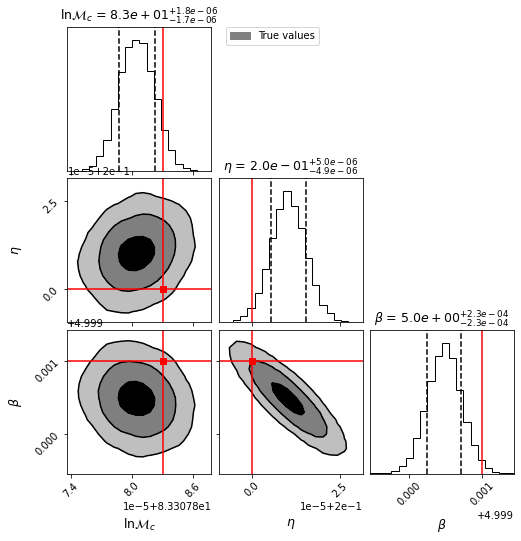

In [19]:
labels = [r'$\ln\mathcal{M}_c$', r'$\eta$', r'$\beta$']
truths=[logMchirp_true,eta_true,beta_true]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='gray', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()

### Bias from the Fisher formalism

Here we calculate the derivatives numerically.
We use finite difference.

In [20]:
# Derivative wrt Mc.

lnMc_delta = 1e-4
pars_p = [pars[0] + lnMc_delta,pars[1],pars[2]]
pars_m = [pars[0] - lnMc_delta,pars[1],pars[2]]
d_dlnMc = (htilde(freq,Deff,pars_p,0)-htilde(freq,Deff,pars_m,0))/(2*lnMc_delta)

# Derivative wrt eta.
eta_delta = 1e-6
pars_p = [pars[0],pars[1] + eta_delta,pars[2]]
pars_m = [pars[0],pars[1] - eta_delta,pars[2]]
d_deta = (htilde(freq,Deff,pars_p,0)-htilde(freq,Deff,pars_m,0))/(2*eta_delta)

# Derivative wrt beta

beta_delta = 1e-6
pars_p = [pars[0],pars[1],pars[2]+ beta_delta]
pars_m = [pars[0],pars[1],pars[2]- beta_delta]
d_dbeta = (htilde(freq,Deff,pars_p,0)-htilde(freq,Deff,pars_m,0))/(2*beta_delta)

In [21]:
"""
Find the Fisher matrix with your approximate waveforms, as this is the
one which is input in the MCMC and is thus the known waveform.
"""
tune_app = 0

diff_vec =[d_dlnMc,d_deta,d_dbeta]

fish_mix = np.eye(3)
for i in range(0,3):
    for j in range(0,3):
        fish_mix[i,j] = inner_prod_FD(diff_vec[i],diff_vec[j],PSD,delta_f)

In [22]:
# errors on lnMc, eta, beta.
print('FM width predictions:',np.sqrt(np.diag(np.linalg.inv(fish_mix))))

"""
Width of posteriors from MCMC. This should be close to the FM
approximation just above.
"""
print('MC width predictions:',  [np.round(np.sqrt(np.var(flat_samples[:,:,0])),17),
                                 np.round(np.sqrt(np.var(flat_samples[:,:,1])),17),
                                 np.round(np.sqrt(np.var(flat_samples[:,:,2])),17)])

FM width predictions: [1.69913933e-06 5.14175879e-06 2.40039979e-04]
MC width predictions: [1.73586843777e-06, 5.05974262802e-06, 0.00023638691606651]


Calculate biases from noise using

$$\Delta\Theta^i_{\text{noise}} =\Gamma^{ij}b_j$$

where the bias vector in this case where biases come from noise is

$$b_j = \left(\frac{\partial h}{\partial \Theta^j}\bigg|\, n_f + \Delta H_\text{conf}\right)$$

In [23]:
# RHS of inner product in source confusion bias vector.

deltah_noise =  n_f 
deltah_sig   =  DeltaH

# Calculate the inner products with respect to delta H_conf.
deriv_inn_prod_lnMc_noise = inner_prod_FD(d_dlnMc,deltah_noise,PSD,delta_f)
deriv_inn_prod_eta_noise  = inner_prod_FD(d_deta,deltah_noise,PSD,delta_f)
deriv_inn_prod_beta_noise = inner_prod_FD(d_dbeta,deltah_noise,PSD,delta_f)


deriv_inn_prod_lnMc_sig = inner_prod_FD(d_dlnMc,deltah_sig,PSD,delta_f)
deriv_inn_prod_eta_sig  = inner_prod_FD(d_deta,deltah_sig,PSD,delta_f)
deriv_inn_prod_beta_sig = inner_prod_FD(d_dbeta,deltah_sig,PSD,delta_f)


# Bias ("b") vector for confusion noise.
b_noise = [deriv_inn_prod_lnMc_noise,deriv_inn_prod_eta_noise,deriv_inn_prod_beta_noise]
b_sig = [deriv_inn_prod_lnMc_sig,deriv_inn_prod_eta_sig,deriv_inn_prod_beta_sig]

# Compute the predicted biases
FM_inv = np.linalg.inv(fish_mix)
biases_pred_noise = np.matmul(FM_inv,b_noise)
biases_pred_sig = np.matmul(FM_inv,b_sig)

# Convert back the biases into non-matrix form.
lnMc_bias_noise = biases_pred_noise[0]
eta_bias_noise = biases_pred_noise[1]
beta_bias_noise = biases_pred_noise[2]

lnMc_bias_sig = biases_pred_sig[0]
eta_bias_sig = biases_pred_sig[1]
beta_bias_sig = biases_pred_sig[2]

bias_v_noise = [lnMc_bias_noise,eta_bias_noise,beta_bias_noise]
bias_v_sig = [lnMc_bias_sig,eta_bias_sig,beta_bias_sig]

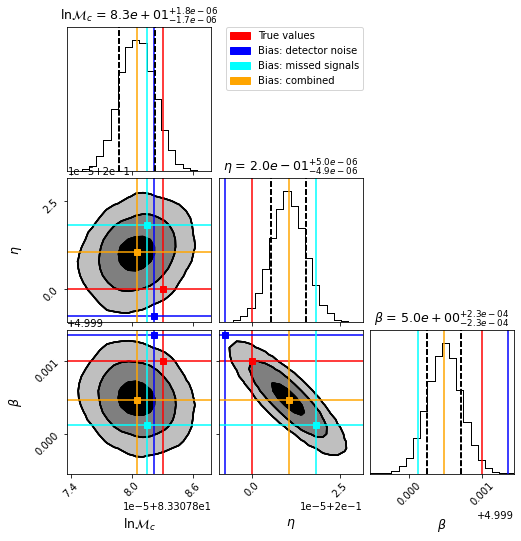

In [24]:
labels = [r'$\ln\mathcal{M}_c$', r'$\eta$', r'$\beta$']
truths=[logMchirp_true,eta_true,beta_true]
truths_bias_noise=[logMchirp_true+lnMc_bias_noise,
                   eta_true+eta_bias_noise,
                   beta_true+beta_bias_noise]
truths_bias_sig=[logMchirp_true+lnMc_bias_sig,
                   eta_true+eta_bias_sig,
                   beta_true+beta_bias_sig]
truths_combined = [logMchirp_true+lnMc_bias_sig+lnMc_bias_noise,
                   eta_true+eta_bias_sig+eta_bias_noise,
                   beta_true+beta_bias_sig+beta_bias_noise]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)
corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths_bias_noise,
                    truth_color='blue', 
                    color='black',**CORNER_KWARGS,fig=fig)
corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths_bias_sig,
                    truth_color='cyan', 
                    color='black',**CORNER_KWARGS,fig=fig)
corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths_combined,
                    truth_color='orange',
                    color='black',**CORNER_KWARGS,fig=fig)

red_patch = mpatches.Patch(color='red', label='True values')
blue_patch = mpatches.Patch(color='blue', label='Bias: detector noise')
cyan_patch = mpatches.Patch(color='cyan', label='Bias: missed signals')
orange_patch = mpatches.Patch(color='orange', label='Bias: combined')
plt.legend(handles=[red_patch,
                    blue_patch,
                    cyan_patch,
                    orange_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()